## Generisanje videa

# Prebrojavanje objekata - video



In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import random
import time
from scipy import ndimage
import math
from sklearn.datasets import fetch_mldata

from vector import pnt2line 

In [44]:
mnist = fetch_mldata('MNIST original')
print mnist.data.shape
print mnist.target.shape
print np.unique(mnist.target)

(70000L, 784L)
(70000L,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


In [45]:
width = 640
height = 480

objs = []
line = [(100,450), (500, 100)]

counter = 0

random.seed(123)

In [46]:
def init():
    for i in range(0, 100):
        tt = random.randint(0,60000)
        mnimage = mnist.data[tt].reshape(28,28)
        xc = random.randint(-1000, width/2)
        yc = random.randint(-1000, height/2)
        objs.append({'x':xc, 'y':yc, 'img':mnimage, 'label':mnist.target[tt], 'pass':False})

In [47]:
def generate_image():
    global counter
    img = np.zeros((height,width,3), np.uint8)
    for i in range(len(objs)):
        obj = objs[i]
        obj['x'] += 1
        if i%2==0:
            obj['y'] += 1
        xc = obj['x']
        yc = obj['y']
        
        dist, pnt = pnt2line((xc, yc), line[0], line[1])
        #cv2.line(img, pnt, (xc, yc), (0, 255, 25), 1)
        c = (255, 25, 160)
        if(dist<5):
            c = (0, 255, 160)
            if obj['pass'] == False:
                obj['pass'] = True
                counter += 1
        #cv2.circle(img, (xc,yc), 16, c, 1)
        if(yc<height-14 and yc>14 and xc>14 and xc<width-14):
            img[yc-14:yc+14, xc-14:xc+14, 0] = obj['img']
            img[yc-14:yc+14, xc-14:xc+14, 1] = obj['img']
            img[yc-14:yc+14, xc-14:xc+14, 2] = obj['img']        
    for i in range(50):
        xc = random.randint(0, width)
        yc = random.randint(0, height)
        cv2.circle(img, (xc,yc), 1, (0, 255, 25), -1)
    cv2.line(img, line[0], line[1] , (255, 0, 0), 3)
    font = cv2.FONT_HERSHEY_COMPLEX
    cv2.rectangle(img, (390,5), (610, 50), (128, 128, 128), -1)
    cv2.putText(img, 'Counter: '+str(counter), (400, 40), font, 1,(90,90,255),2)    
    return img

In [48]:
# Define the codec and create VideoWriter object
#fourcc = cv2.cv.CV_FOURCC(*'XVID')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 40.0, (640,480))

init()
for j in range(1200):
    img = generate_image()
    out.write(img)
out.release()

# Analiza videa

In [49]:
from skimage.io import imread
from scipy import ndimage
import cv2
import numpy as np

In [50]:
cap = cv2.VideoCapture("output.avi")

for j in range(0,10):
    ret, frame = cap.read()
    file_name  = 'images/frame-'+str(j)+'.png'
    cv2.imwrite(file_name, frame)
cap.release()

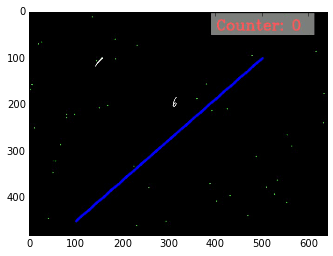

In [51]:

img = imread('images/frame-0.png')  # img je Numpy array
plt.imshow(img)

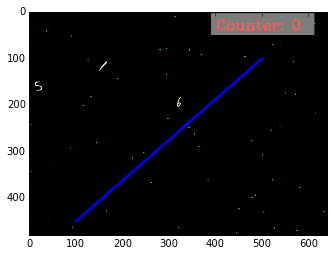

In [52]:
img = imread('images/frame-9.png')  # img je Numpy array
plt.imshow(img)

## Aritmetičke operacije

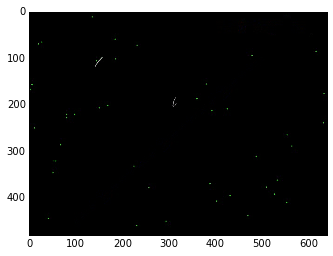

In [53]:
img0 = imread('images/frame-0.png')
img9 = imread('images/frame-1.png')

acc = cv2.subtract(img0, img9)
plt.imshow(acc)

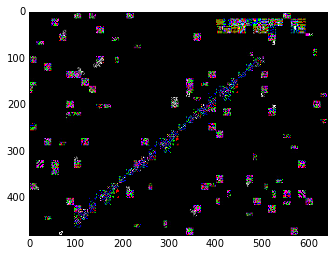

In [54]:
acc = np.absolute(img0 - img9)
plt.imshow(acc)

## Analiza delova slike

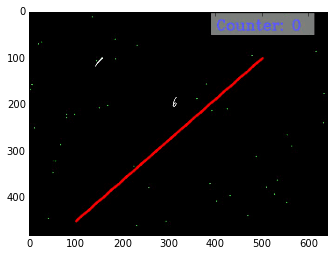

In [55]:
img = cv2.imread('images/frame-0.png')
plt.imshow(img)
(h,w,c) = img.shape


# Define the codec and create VideoWriter object
#fourcc = cv2.cv.CV_FOURCC(*'XVID')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output-rez.avi',fourcc, 50.0, (640,480))

for y in np.arange(14, h-14, 20):
    for x in np.arange(14, w-14, 4):
        imgC = np.copy(img)
        v = img[y-14:y+14, x-14:x+14, 0]
        c = (255,0,0)
        if np.sum(v>10)>100:
            c = (0, 255, 0)
        cv2.rectangle(imgC, (x-14, y-14), (x+14, y+14), c, 1)
        out.write(imgC)
out.release()


# Kako odrediti prag za segmentaciju?


if np.sum(v>10)>100:
     c = (0, 255, 0)

<Container object of 157 artists>

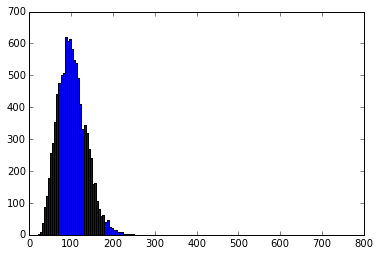

In [56]:
mnist = fetch_mldata('MNIST original')

data   = mnist.data / 255.0

train_rank = 10000
#------- MNIST subset --------------------------
train_subset = np.random.choice(data.shape[0], train_rank)

mask = np.ones((784,1))
k = 1/mask.sum()

bins = np.arange(0,785,5)
hist = np.zeros(bins.shape)

for img in data[train_subset]:
    v = k*np.sum(mask*img)
    hist[int(v/5)]+=1

plt.bar(bins, hist, width=5)

<Container object of 157 artists>

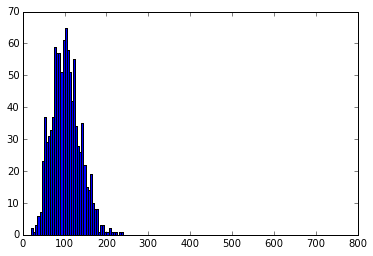

In [57]:
train_rank = 1000
train_subset = np.random.choice(data.shape[0], train_rank)

hist = np.zeros(bins.shape)
X = []

for img in data[train_subset]:
    v = k*np.sum(mask*img)
    hist[int(v/5)]+=1
    X.append(v)

plt.bar(bins, hist, width=5)

Ako je ovo normalna raspodela koji su parametri?

In [58]:
mean = np.mean(X)
print mean

102.661121569


In [59]:
std = np.std(X)
print std 

34.1452709964


## Gausian funkcija

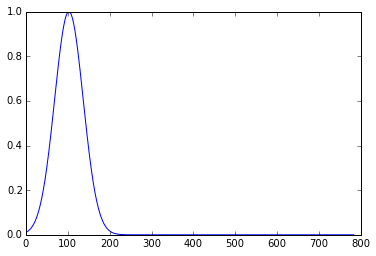

In [60]:
num = math.exp(-(v-mean)**2/(2*std**2))

def gausian(x, m, s):
    return math.exp(-(x-m)**2/(2*s**2))

def gausian2(x, m, s):
    return np.exp(-(x-m)**2/(2*s**2))

x = np.arange(0,784)
y = gausian2(x, mean, std)

plt.plot(x, y)

Ako znamo parametre kako da ovo koristimo?

In [61]:
img0 = imread('images/frame-0.png')
y = 115
x = 115

blok = img0[y-14:y+14, x-14:x+14, 0]
blok = blok.flatten()/255.0
v = k*np.sum(mask*blok)
print v

0.0


In [62]:
num = gausian(v, mean, std)
print num

0.0108910126333


In [63]:
y = 227
x = 340

blok = img0[y-14:y+14, x-14:x+14, 0]
blok = blok.flatten()/255.0
v = k*np.sum(mask*blok)
print v
num = gausian(v, mean, std)
print num

1.8
0.0127437900448


In [67]:
for x in np.arange(250, 350, 5):
    for y in np.arange(180, 250, 5):
        blok = img0[y-14:y+14, x-14:x+14, 0]
        blok = blok.flatten()/255.0
        v = k*np.sum(mask*blok)
        num = gausian(v, mean, std)
        if(num>0.4):
            print (v, num, x, y)

(60.992156862745084, 0.4749150588212474, 305, 190)
(64.764705882352956, 0.5401584107681217, 305, 195)
(62.270588235294134, 0.4967693716235304, 305, 200)
(61.094117647058809, 0.47664670672033527, 310, 190)
(64.88235294117645, 0.5422247133930798, 310, 195)
(62.360784313725475, 0.49832230806057987, 310, 200)
(61.094117647058816, 0.4766467067203354, 315, 190)
(64.882352941176464, 0.54222471339308, 315, 195)
(62.360784313725475, 0.49832230806057987, 315, 200)
(60.882352941176471, 0.4730525248437043, 320, 190)
(64.62745098039214, 0.5377496059170497, 320, 195)
(62.125490196078445, 0.4942740808429688, 320, 200)


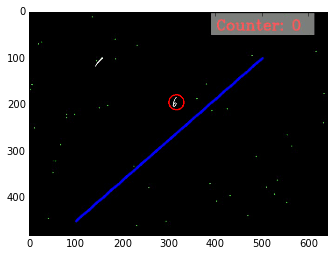

In [70]:
cv2.circle(img0, (315, 195), 16, c, 2)
plt.imshow(img0)